My objective is to identify any Construction and Demolition (C&D) waste landfills within the specified area of interest.

I have obtained the .tif image data from Esri World Imagery in ArcGIS, available at the following link:

https://www.arcgis.com/home/item.html?id=10df2279f9684e4a9f6a7f08febac2a9

The code provided below is used to crop the image into smaller sections of 512×512 pixels. Each cropped section represents an observation in the dataset.

In [ ]:
import os
import random
from osgeo import gdal
import numpy as np

# Function to read a TIFF file
def readTif(fileName):
    dataset = gdal.Open(fileName)
    if dataset is None:
        print(fileName + " file cannot be opened")
    return dataset


In [ ]:
# Function to save a TIFF file
# Output file after clipping
def writeTiff(im_data, im_geotrans, im_proj, path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
        im_bands, im_height, im_width = im_data.shape
    # Create file
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if dataset is not None:
        dataset.SetGeoTransform(im_geotrans)  # Write affine transformation parameters
        dataset.SetProjection(im_proj)  # Write projection information
    for i in range(im_bands):
        dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    del dataset


**Sliding window clipping function**

TifPath: Path to the input image

SavePath: Directory to save the clipped output

CropSize: Clipping size (height and width of the clip)

RepetitionRate: Overlap rate between adjacent clips

In [ ]:
def TifCrop(TifPath, SavePath, CropSize, RepetitionRate):
    dataset_img = readTif(TifPath)
    width = dataset_img.RasterXSize
    height = dataset_img.RasterYSize
    proj = dataset_img.GetProjection()
    geotrans = dataset_img.GetGeoTransform()
    img = dataset_img.ReadAsArray(0, 0, width, height)  # Get image data

    # Get the current number of files in the directory and use it as the starting file name for new clips
    new_name = len(os.listdir(SavePath)) + 1

    # Clip the image using the specified overlap rate (RepetitionRate)
    for i in range(int((height - CropSize * RepetitionRate) / (CropSize * (1 - RepetitionRate)))):
        for j in range(int((width - CropSize * RepetitionRate) / (CropSize * (1 - RepetitionRate)))):
            # If the image is single-band
            if len(img.shape) == 2:
                cropped = img[
                          int(i * CropSize * (1 - RepetitionRate)): int(i * CropSize * (1 - RepetitionRate)) + CropSize,
                          int(j * CropSize * (1 - RepetitionRate)): int(j * CropSize * (1 - RepetitionRate)) + CropSize]
            # If the image is multi-band
            else:
                cropped = img[:,
                          int(i * CropSize * (1 - RepetitionRate)): int(i * CropSize * (1 - RepetitionRate)) + CropSize,
                          int(j * CropSize * (1 - RepetitionRate)): int(j * CropSize * (1 - RepetitionRate)) + CropSize]
            # Write the clipped image to a file
            writeTiff(cropped, geotrans, proj, SavePath + "/%d.tif" % new_name)
            # Increment the file name
            new_name += 1

    # Clip the last column
    for i in range(int((height - CropSize * RepetitionRate) / (CropSize * (1 - RepetitionRate)))):
        if len(img.shape) == 2:
            cropped = img[int(i * CropSize * (1 - RepetitionRate)): int(i * CropSize * (1 - RepetitionRate)) + CropSize,
                      (width - CropSize): width]
        else:
            cropped = img[:,
                      int(i * CropSize * (1 - RepetitionRate)): int(i * CropSize * (1 - RepetitionRate)) + CropSize,
                      (width - CropSize): width]
        # Write the clipped image to a file
        writeTiff(cropped, geotrans, proj, SavePath + "/%d.tif" % new_name)
        new_name += 1

    # Clip the last row
    for j in range(int((width - CropSize * RepetitionRate) / (CropSize * (1 - RepetitionRate)))):
        if len(img.shape) == 2:
            cropped = img[(height - CropSize): height,
                      int(j * CropSize * (1 - RepetitionRate)): int(j * CropSize * (1 - RepetitionRate)) + CropSize]
        else:
            cropped = img[:,
                      (height - CropSize): height,
                      int(j * CropSize * (1 - RepetitionRate)): int(j * CropSize * (1 - RepetitionRate)) + CropSize]
        # Write the clipped image to a file
        writeTiff(cropped, geotrans, proj, SavePath + "/%d.tif" % new_name)
        new_name += 1

    # Clip the bottom-right corner
    if len(img.shape) == 2:
        cropped = img[(height - CropSize): height,
                  (width - CropSize): width]
    else:
        cropped = img[:,
                  (height - CropSize): height,
                  (width - CropSize): width]
    # Write the clipped image to a file
    writeTiff(cropped, geotrans, proj, SavePath + "/%d.tif" % new_name)
    new_name += 1


**Random cropping function**

ImagePath: Path to the original image

LabelPath: Path to the label image

IamgeSavePath: Directory to save cropped original images

LabelSavePath: Directory to save cropped label images

CropSize: Size of the crop (height and width)

CutNum: Number of crops to generate

In [ ]:
def RandomCrop(ImagePath, LabelPath, IamgeSavePath, LabelSavePath, CropSize, CutNum):
    dataset_img = readTif(ImagePath)
    width = dataset_img.RasterXSize
    height = dataset_img.RasterYSize
    proj = dataset_img.GetProjection()
    geotrans = dataset_img.GetGeoTransform()
    img = dataset_img.ReadAsArray(0, 0, width, height)  # Get original image data
    dataset_label = readTif(LabelPath)
    label = dataset_label.ReadAsArray(0, 0, width, height)  # Get label data

    # Get the current number of files in the directory and use it as the starting file name for new crops
    fileNum = len(os.listdir(IamgeSavePath))
    new_name = fileNum + 1
    while new_name < CutNum + fileNum + 1:
        # Generate the top-left XY coordinates for the crop
        UpperLeftX = random.randint(0, height - CropSize)
        UpperLeftY = random.randint(0, width - CropSize)
        if len(img.shape) == 2:
            imgCrop = img[UpperLeftX: UpperLeftX + CropSize,
                          UpperLeftY: UpperLeftY + CropSize]
        else:
            imgCrop = img[:,
                          UpperLeftX: UpperLeftX + CropSize,
                          UpperLeftY: UpperLeftY + CropSize]
        if len(label.shape) == 2:
            labelCrop = label[UpperLeftX: UpperLeftX + CropSize,
                              UpperLeftY: UpperLeftY + CropSize]
        else:
            labelCrop = label[:,
                              UpperLeftX: UpperLeftX + CropSize,
                              UpperLeftY: UpperLeftY + CropSize]
        # Save the cropped original image and label image
        writeTiff(imgCrop, geotrans, proj, IamgeSavePath + "/%d.tif" % new_name)
        writeTiff(labelCrop, geotrans, proj, LabelSavePath + "/%d.tif" % new_name)
        new_name += 1

In [ ]:

# Training set Generation
# Generate 512×512 training dataset images through random cropping
RandomCrop(r"C:\MyNuts\\Class\Environmental Data\data\test\0194.tif",
           r"C:\MyNuts\\Class\Environmental Data\data\label\l_31.tif",
           r"C:\MyNuts\\Class\Environmental Data\data\result_rand",
           r"C:\MyNuts\\Class\Environmental Data\data\result_rand_1",
           512, 5)

# Crop the image into 512×512 segments with a repetition rate of 0
TifCrop(r"C:\MyNuts\\Class\Environmental Data\data\test\0194.tif",
        r"C:\MyNuts\\Class\Environmental Data\data\result_seq", 512, 0)
TifCrop(r"C:\MyNuts\\Class\Environmental Data\data\label\l_31.tif",
        r"C:\MyNuts\\Class\Environmental Data\data\result_seq_l", 512, 0)



**Below are some sample images after cropping. A total of 2,867 images have been generated through the cropping process.**


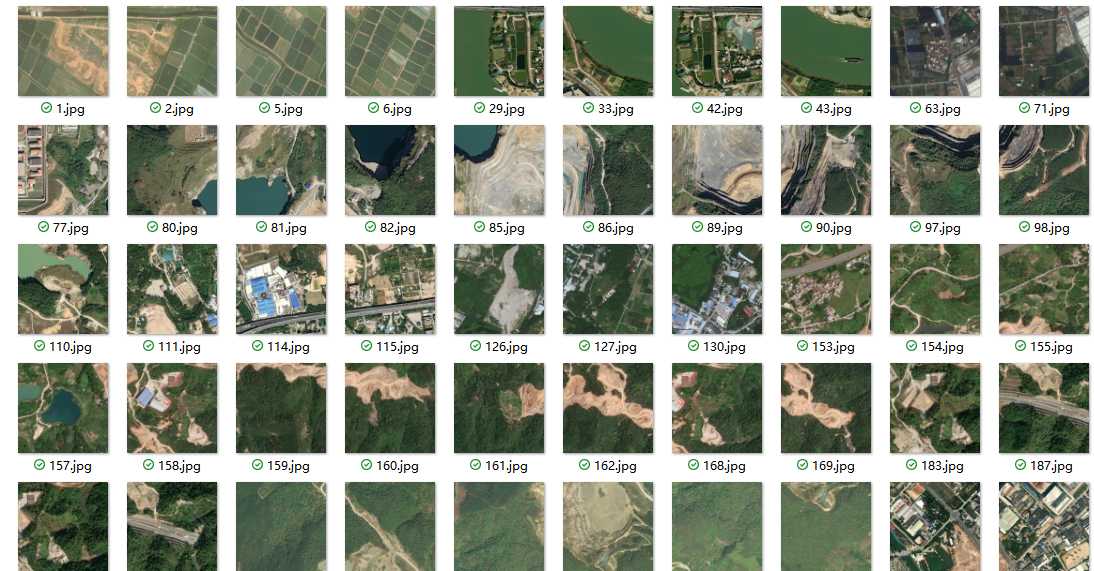

**The presence of waste landfills in the cropped images is determined manually.**

If a landfill is present in the image, the label is assigned as 1.

If no landfill is present, the label is assigned as 0.


**The dataset includes:**

landfill(1) : 1,884 instances

no landfill (0) : 983 instances



In [3]:
import pandas as pd
df = pd.read_csv(r"C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\labels.csv")
df["Label"].describe()

count    2867.000000
mean        0.657133
std         0.474750
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Label, dtype: float64

In [7]:
print(df.head(20))

   File Name  Label
0      1.png      1
1      2.png      1
2      5.png      0
3      6.png      0
4     29.png      0
5     33.png      0
6     42.png      1
7     43.png      1
8     63.png      0
9     71.png      0
10    77.png      1
11    80.png      0
12    81.png      1
13    82.png      1
14    85.png      1
15    86.png      1
16    89.png      1
17    90.png      1
18    97.png      1
19    98.png      1


**Train-Test Split**
The dataset is divided into a training set and a test set in an 80:20 ratio.

To ensure label balance and fairness in the test set, we ensured that the number of images with landfills and without landfills was equal (1:1) when splitting the dataset.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the dataset
file_path = r"C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\labels.csv"
data = pd.read_csv(file_path)

# Separate the data by labels (0 and 1)
data_label_1 = data[data['Label'] == 1]  # Data with Label=1
data_label_0 = data[data['Label'] == 0]  # Data with Label=0

# Ensure the test set has an equal number of 0 and 1 labels
test_size = min(len(data_label_0), len(data_label_1)) // 5  # 20% of the smaller class for each label in the test set

# Randomly sample test data from both Label=0 and Label=1 datasets
test_0 = data_label_0.sample(n=test_size, random_state=42)
test_1 = data_label_1.sample(n=test_size, random_state=42)

# The remaining data becomes the training set
train_0 = data_label_0.drop(test_0.index)  # Remaining data with Label=0
train_1 = data_label_1.drop(test_1.index)  # Remaining data with Label=1

# Mark the training and test sets
train_0['Set'] = 'Train'
train_1['Set'] = 'Train'
test_0['Set'] = 'Test'
test_1['Set'] = 'Test'

# Combine the training and test sets and shuffle the data
final_data = pd.concat([train_0, train_1, test_0, test_1]).sample(frac=1, random_state=42)

# Save the final dataset with the 'Set' column to a new file
output_file = r"C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\labels_with_set.csv"
final_data.to_csv(output_file, index=False)

print(f"Dataset with train/test labels saved to: {output_file}")


Dataset with train/test labels saved to: C:\MyNuts\我的坚果云\Class\Environmental Data\final_project\labels_with_set.csv


In [9]:
# Separate the training set and test set based on the 'Set' column
train_data = final_data[final_data['Set'] == 'Train']  # Filter rows where 'Set' is 'Train'
test_data = final_data[final_data['Set'] == 'Test']    # Filter rows where 'Set' is 'Test'

# Total number of samples in the entire dataset
print("Statistics:")
print("Total number of samples:", len(final_data))

# Training set statistics
print("\nTrain Set:")
print(train_data['Label'].value_counts())  
print("Train Set Size:", len(train_data))

# Test set statistics
print("\nTest Set:")
print(test_data['Label'].value_counts())  
print("Test Set Size:", len(test_data))

# Overall label distribution in the entire dataset
print("\nOverall Label Distribution:")
print(final_data['Label'].value_counts())

Statistics:
Total number of samples: 2867

Train Set:
Label
1    1688
0     787
Name: count, dtype: int64
Train Set Size: 2475

Test Set:
Label
1    196
0    196
Name: count, dtype: int64
Test Set Size: 392

Overall Label Distribution:
Label
1    1884
0     983
Name: count, dtype: int64


The assignment of each image to either the training set or the test set is recorded in a CSV file.

In [13]:
final_data.head(20)

,File Name,Label,Set
1927,eng046.png,0,Train
1267,5902.png,1,Train
2833,ro1377.png,0,Train
2271,ro211.png,0,Train
2524,ro732.png,1,Test
1017,4772.png,1,Train
1258,5871.png,1,Train
2538,ro761.png,1,Train
6,42.png,1,Train
668,3047.png,0,Test
